In [105]:
import pandas as pd
# cspell:disable
import streamlit as st
import joblib




In [4]:
from google.colab import files
import pandas as pd

# This will open a file picker in Colab
uploaded = files.upload()


Saving fake_or_real_news.csv to fake_or_real_news (1).csv


In [6]:
df = pd.read_csv("fake_or_real_news.csv")

In [7]:
print(df.head())

   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB
None


In [9]:
print(df.isnull().sum())


Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


DATA CLEANING

In [24]:
df['content'] = df['title'].fillna('') + " " + df['text'].fillna('')


In [42]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

In [20]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [21]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [25]:
def clean_text(text):
    text = str(text).lower()  # convert to string & lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # remove URLs
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters
    text = ' '.join([lemmatizer.lemmatize(word)
                     for word in text.split() if word not in stop_words])
    return text

df['clean_content'] = df['content'].apply(clean_text)

print(df[['content', 'clean_content']].head())

                                             content  \
0  You Can Smell Hillary’s Fear Daniel Greenfield...   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2  Kerry to go to Paris in gesture of sympathy U....   
3  Bernie supporters on Twitter erupt in anger ag...   
4  The Battle of New York: Why This Primary Matte...   

                                       clean_content  
0  smell hillary fear daniel greenfield shillman ...  
1  watch exact moment paul ryan committed politic...  
2  kerry go paris gesture sympathy u secretary st...  
3  bernie supporter twitter erupt anger dnc tried...  
4  battle new york primary matter primary day new...  


In [26]:
df = df.drop_duplicates(subset=['clean_content'])


In [27]:
print(df['label'].value_counts())


label
REAL    3153
FAKE    3150
Name: count, dtype: int64


In [28]:
df.to_csv("clean_fake_news.csv", index=False)


DATA VISIUALIZATION

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns


/tmp/ipython-input-2063730795.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='Set2')


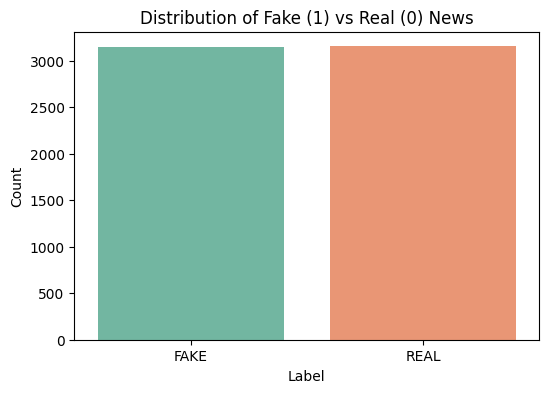

In [31]:
# 1. Class Distribution (Fake vs Real)
plt.figure(figsize=(6,4))
sns.countplot(x=df['label'], palette='Set2')
plt.title("Distribution of Fake (1) vs Real (0) News")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


/tmp/ipython-input-3781622534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['clean_content'].apply(len)


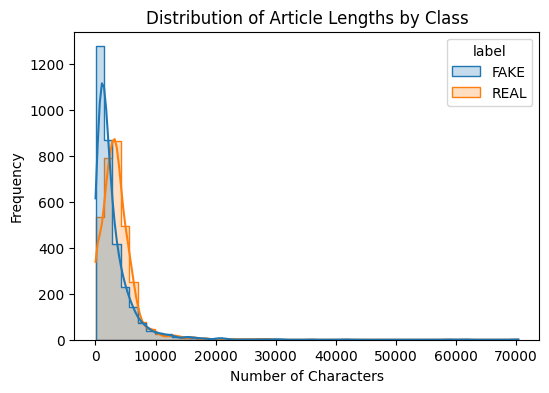

In [32]:
# 2. Length of Articles
df['text_length'] = df['clean_content'].apply(len)

plt.figure(figsize=(6,4))
sns.histplot(data=df, x='text_length', bins=50, hue='label', element='step', kde=True)
plt.title("Distribution of Article Lengths by Class")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()


/tmp/ipython-input-3026792269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df['clean_content'].apply(lambda x: len(x.split()))
/tmp/ipython-input-3026792269.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='word_count', data=df, palette="Set3")


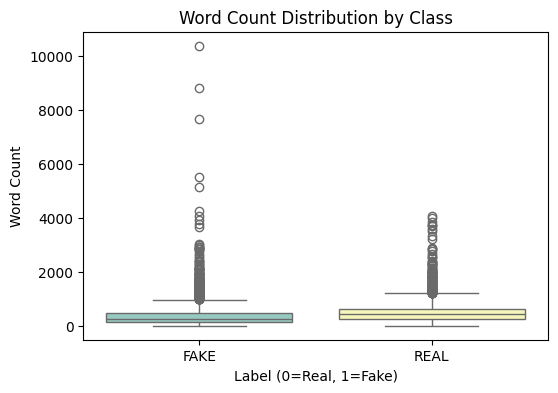

In [35]:
# 5. Average Word Count per Class
df['word_count'] = df['clean_content'].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.boxplot(x='label', y='word_count', data=df, palette="Set3")
plt.title("Word Count Distribution by Class")
plt.xlabel("Label (0=Real, 1=Fake)")
plt.ylabel("Word Count")
plt.show()

DATA PREPOCESSING

In [39]:
X = df['clean_content']
y = df['label']

In [44]:
# ======================================
# 8. Train-Test Split
# ======================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 5042
Testing samples: 1261


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [46]:
# Convert text into TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shape (train):", X_train_tfidf.shape)
print("TF-IDF shape (test):", X_test_tfidf.shape)

TF-IDF shape (train): (5042, 5000)
TF-IDF shape (test): (1261, 5000)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [48]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)

y_pred_log = log_reg.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9238699444885012

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.90      0.96      0.93       630
        REAL       0.96      0.89      0.92       631

    accuracy                           0.92      1261
   macro avg       0.93      0.92      0.92      1261
weighted avg       0.93      0.92      0.92      1261



In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

y_pred_rf = rf_model.predict(X_test_tfidf)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9103885804916733

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.89      0.94      0.91       630
        REAL       0.94      0.88      0.91       631

    accuracy                           0.91      1261
   macro avg       0.91      0.91      0.91      1261
weighted avg       0.91      0.91      0.91      1261



In [52]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.8778747026169706

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.85      0.91      0.88       630
        REAL       0.91      0.84      0.87       631

    accuracy                           0.88      1261
   macro avg       0.88      0.88      0.88      1261
weighted avg       0.88      0.88      0.88      1261



In [54]:
from sklearn.svm import LinearSVC

In [55]:
# --- Train SVM ---
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

In [56]:
results = {
    "Logistic Regression": accuracy_score(y_test, y_pred_log),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "Naive Bayes": accuracy_score(y_test, y_pred_nb),
    "SVM": accuracy_score(y_test, y_pred_svm)
}

print("\n📊 Model Comparison:", results)


📊 Model Comparison: {'Logistic Regression': 0.9238699444885012, 'Random Forest': 0.9103885804916733, 'Naive Bayes': 0.8778747026169706, 'SVM': 0.9405233941316415}


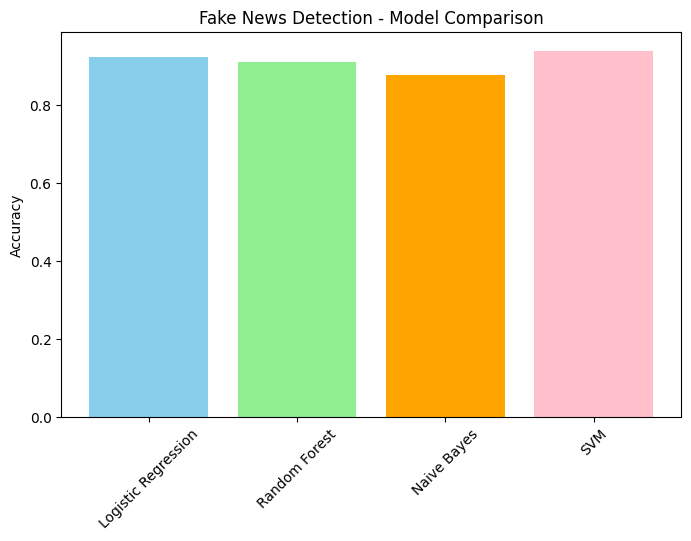

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values(), color=['skyblue','lightgreen','orange','pink','purple'])
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Fake News Detection - Model Comparison")
plt.show()
